# Выявление определяющих закономерностей успешности игры

## Цели:

* Изучить общую информацию;
* Подготовить данные к обработке;
* Исследовать данные;
* Составить портрет пользователя каждого региона;
* Проверить гипотезы о равенстве отзывов о играх разных жанров, платформ;
* Агрегировать полученные зависимости в общий вывод.

[Шаг 1. Изучение общей информации](#step1)

[Шаг 2. Подготовка данных](#step2)
- [Замена названий столбцов](#change_name_columns)
- [Обработка пропусков](#processing_passes)
  - [Вычленение зависимостей для заполнение пропусков](#isolating_dependencies)
  - [Вывод о зависимостях для заполнение пропусков](#conclusion_dependencies)
  - [Заполнение пропусков](#filling_omissions)
- [Преобразование данных](#transformation_name_columns) 

[Шаг 3. Исследовательский анализ данных](#step3)
- [Количество игр по годам](#count_plays)
- [Измененение продаж по платформам и годам](#change_salary)
- [Количество игр по годам и платформам](#count_plays_conditions)
- [Данные за актуальный период](#actual_data)
- [Построение boxplot'ов по платформам](#boxplots)
- [Влияние отзывов на число продаж](#influence_review)
- [Влияние жанров на продажи](#influence_genres)
- [Первично обнаруженные закономерности](#primary_patterns)

[Шаг 4. Портрет пользователя каждого региона](#portrait_by_regions)
- [Самые популярные платформы](#famous_platforms)
- [Самые популярные жанры](#famous_genres)
- [Влияние ESRB на продажи в регионах](#ESRB_seller)
- [Выводы о специфичности регионов](#specific_regions)

[Шаг 5. Проверка гипотез](#step5)
- [Гипотеза 1](#hyp1)
    - [Проверка равенства дисперсий выборок рейтингов платформ Xbox One и PC](#var_rating_platform)
    - [Проверка равенства средних  пользовательских рейтингов платформ Xbox One и PC](#mean_platform)
    - [Вывод на основе гипотезы 1](#conclusion_hyp1)
 
- [Гипотеза 2](#hyp2)
    - [Проверка равенства дисперсий выборок рейтингов жанров Action и Sports](#var_rating_action)
    - [Проверка равенства рейтингов жанров Action и Sports](#mean_genre)
    - [Вывод на основе гипотезы 2](#conclusion_hyp2)
    
[Шаг 6. Общий вывод](#general_conclusion) 

In [1]:
%%capture
!pip install --upgrade pingouin

## Шаг 1. Изучение общей информации <a name="step1"></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import math
import bisect
from scipy import stats as st
from matplotlib import pyplot
from matplotlib.pyplot import hist
import scipy.stats as stats
import pingouin as pg
from collections import Counter

In [3]:
games_df = pd.read_csv('/datasets/games.csv') 
games_df.info()
display(games_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Таблица состоит из следующих столбцов:
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Всего лишь 2 пропущенных значения в имени и жанре, 269 (1.6%) годов выпуска не указаны, 8578 (51.3%) оценок критиков и 6701 (40%) оценок пользователей неизвестны, значение рейтинга от организации ESRB не задано в 6766 (40.4%) строках. Количество пропусков не одинаково, их причины могут быть различны, подходы к их устранению также будут отличаться и описаны ниже.

## Шаг 2. Подготовка данных  <a name="step2"></a>

### Замена название столбцов <a name="change_name_columns"></a>

In [4]:
games_df.columns= games_df.columns.str.lower()
games_df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Обработка пропусков <a name="processing_passes"></a>

#### Вычленение зависимостей для заполнение пропусков <a name="isolating_dependencies"></a>

40.84% - Процент игр, по которым пытаемся обнаружить полезные закономерности


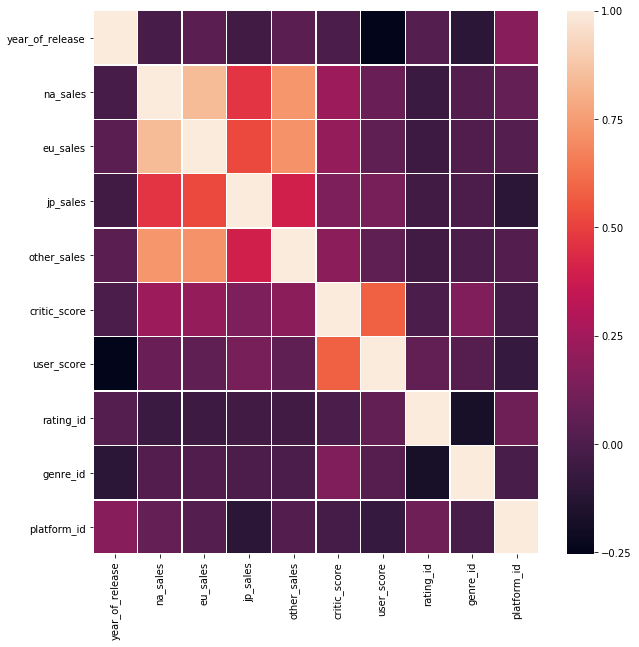

In [5]:
df_without_nan = games_df.dropna()
df_without_nan = df_without_nan.query('user_score != "tbd"')

df_without_nan['rating_id'] = df_without_nan['rating'].astype('category')
cat_columns = df_without_nan.select_dtypes(['category']).columns
df_without_nan['rating_id'] = df_without_nan[cat_columns].apply(lambda x: x.cat.codes)

df_without_nan['genre_id'] = df_without_nan['genre'].astype('category')
cat_columns = df_without_nan.select_dtypes(['category']).columns
df_without_nan['genre_id'] = df_without_nan[cat_columns].apply(lambda x: x.cat.codes)

df_without_nan['platform_id'] = df_without_nan['platform'].astype('category')
cat_columns = df_without_nan.select_dtypes(['category']).columns
df_without_nan['platform_id'] = df_without_nan[cat_columns].apply(lambda x: x.cat.codes)

df_without_nan['user_score'] = df_without_nan['user_score'].astype(float)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_without_nan.corr(),linewidths=.5, ax=ax);
print('{:.2%} - Процент игр, по которым пытаемся обнаружить полезные закономерности'.
      format(df_without_nan.count()['name'] / games_df.count()['name']))

#### Вывод о зависимостях для заполнение пропусков <a name="conclusion_dependencies"></a>

Да, после удаления строк с пропусками осталось лишь 40% значений от изначального количества, но для поиска закономерностей по замене пропущенных значений иных вариантов нет. 

Значимых зависимостей для интересующих нас столбцов (Critic_Score, User_Score, Rating) не обнаружено в связи с чем адекватные - информативные замены осуществить невозможно.

#### Заполнение пропусков <a name="filling_omissions"></a>

In [6]:
old_count_nan = games_df.query('year_of_release.isnull()')['user_score'].count()

def years_from_title_game(row):
    year_for_input = row['year_of_release']
    if math.isnan(year_for_input):
        if row['name'][-4:].isnumeric():
            year_for_input = row['name'][-4:]

    return year_for_input

games_df['year_of_release'] = games_df.apply(years_from_title_game, axis=1)

print(old_count_nan - games_df.query('year_of_release.isnull()')['user_score'].count(), 
      '- количество пропусков, которые удалось вытащить из названия')

11 - количество пропусков, которые удалось вытащить из названия


In [7]:
platforms_pass_years = games_df.query('year_of_release.isnull()')['platform'].unique()

def generate_aggregated_df(platforms_pass_years):
    values_for_df = []
    
    for platform in platforms_pass_years:
        values_for_df.append(games_df.query('platform == @platform')['year_of_release'].median())
    
    platform_median_year_df = pd.DataFrame(values_for_df, index=platforms_pass_years)

    return platform_median_year_df
try:
    games_df['year_of_release'].fillna(games_df.query('year_of_release.isnull()')['platform'].
                                   map(dict(generate_aggregated_df(platforms_pass_years)[0])), inplace =True)
except:
    print('Пропусков уже нет')
print(f"{games_df.query('year_of_release.isnull()')['user_score'].count()} - количество оставшихся пропусков дат после замены")

0 - количество оставшихся пропусков дат после замены


In [8]:
games_df.info()

display(games_df.query('name.isnull()'))
print('Игры для которых не указано имя и жанр.')
games_df.dropna(inplace=True, subset=['name'])

display(games_df.corr())

games_df['rating'].fillna('pass_rating',inplace=True)
games_df['critic_score'].fillna('-1',inplace=True)

games_df['user_score'].fillna('-0.1', inplace=True)
games_df['user_score'].replace('tbd', -0.1, inplace=True)

games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16715 non-null object
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(5), object(6)
memory usage: 1.4+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Игры для которых не указано имя и жанр.


,na_sales,eu_sales,jp_sales,other_sales,critic_score
na_sales,1.000000,0.765341,0.449668,0.638695,0.240755
eu_sales,0.765341,1.000000,0.435079,0.722796,0.220752
jp_sales,0.449668,0.435079,1.000000,0.291090,0.152593
other_sales,0.638695,0.722796,0.291090,1.000000,0.198554
critic_score,0.240755,0.220752,0.152593,0.198554,1.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null object
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       16713 non-null object
user_score         16713 non-null object
rating             16713 non-null object
dtypes: float64(4), object(7)
memory usage: 1.5+ MB


* В столбцах name и genre пропуски малочисленны, невосполнимы, стары в связи с чем просто удалил их;
* В столбце year_of_release заменил пропуски на где это возможно значения из названия, в оставшихся случаях посчитал, что исходя из платформы возможно предположить год, допустил, что такой заменой является медианное значение для каждой платформы;

* Что касается замен рейтингов:
    * Зависимостей по имеющимся данным выявлено не было;
    * Заменять на какое-то среднее или медианное значение считаю невозможным, по причине потери информации от действительно указанных и не указанных игр;
    * Пропущенные оценки критиков и пользователей заменил некорректным значением -1, для дальнейшей обработки, rating - значением 'pass_rating' для той же цели.

tbd 'to be determined' - будет определен, демонстрирует, что значение пока неизвестно.
tbd - заменил на -2, чтобы не иметь проблемы с приведением типа.

Выделяю следующие причины возникновения пропусков:
* Отсутствие каких-то параметров о строках;
* Еще несформированные характеристики для игр;
* Новизна рейтинга, относительно некоторых игр;
* Сертификационный центр не успел присвоить рейтинг.

### Преобразование данных <a name="transformation_name_columns"></a>

In [9]:
games_df['total_sales'] = games_df['na_sales'] + games_df['eu_sales'] + games_df['jp_sales']
games_df['critic_score'] = games_df['critic_score'].astype(int)
games_df['year_of_release'] = games_df['year_of_release'].astype(int)
games_df['user_score'] = games_df['user_score'].astype(float)
games_df['user_score'] = 10 * games_df['user_score']
games_df['user_score'] = games_df['user_score'].astype(int)

In [10]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       16713 non-null int64
user_score         16713 non-null int64
rating             16713 non-null object
total_sales        16713 non-null float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.7+ MB


Произвел следующеее приведение типов в различных столбцах:
* year_of_release - привел тип, по причине удоства работы с int'oм;
* Объемы продаж указаны в миллионах и округлять считаю нецелесообразным;
* critic_score - неизвестные оценки были заменены уникальными численными значением в связи с чем приведение типов в столбце с оценкой критиков стало возможно;
* user_score - заменил пропуски на -1, 'tbd', которое ограничивало приведение типов также на -1, для удобства дальнейшей обработки, при этом домножил на 10 оценки, чтобы привести данные к типу int  и сравнять шкалы оценок как пользователей, так и критиков;
* Значения столбца rating - категориальные, которые можно заменить численными значениями, но это будет менее информативно в связи с чем тип данных оставлен без изменений.

## Шаг 3. Исследовательский анализ данных <a name="step3"></a>


### Количество игр по годам<a name="count_plays"></a>

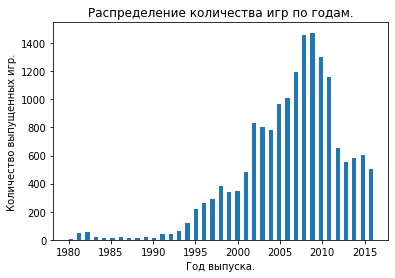

In [11]:
games_df['year_of_release'].plot(kind='hist', bins=73)
plt.title("Распределение количества игр по годам.")
plt.xlabel("Год выпуска.")
plt.ylabel("Количество выпущенных игр.");

Разброс по годам кардинальный, но для выявления закономерностей информации достаточно, до 2008 года существовала тенденция ежегодного увеличения числа выпускаемых игр, однако начиная с 2009 количество игр начало уменьшаться, при этом после резкого падения числа игр в 2012 году (в 1.73 раза) уменьшение числа игр стало более плавным. В связи с чем, считаю важным рассмотрение значений лишь  с 2012 года и позже. Причиной столь резкого падения числа игр в 2012 считаю:
* Повышение сложности создания отдельной игры;
* По информации на Metacritic (сайт-агрегатор отзывов), лучших игр десятилетия 2010-2019 до 2016 года - 33, 11 из них были выпущены в 2011, окончание работы по столь большому количество признанных проектов считаю одним из оснований по снижению числа игр в 2012. 

### Измененение продаж по платформам и годам<a name="change_salary"></a>

In [12]:
ten_the_most_profitable_platform = games_df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)[:10]
print('{:.2%} - Процент дохода от 10 самых прибыльных платформ'.
      format(ten_the_most_profitable_platform.sum() / games_df['total_sales'].sum()))

ten_the_most_profitable_platform

75.04% - Процент дохода от 10 самых прибыльных платформ


platform
PS2     1062.33
X360     885.66
Wii      828.44
PS3      803.97
DS       746.86
PS       689.95
GBA      310.12
PS4      265.79
PSP      252.63
XB       249.02
Name: total_sales, dtype: float64

In [13]:
data_for_plot = pd.DataFrame(index = games_df['year_of_release'].value_counts().index.astype(int))

for platform in ten_the_most_profitable_platform.index:
    data_for_plot[platform] = games_df.query('platform == @platform').groupby('year_of_release')['total_sales'].sum()
    
data_for_plot.fillna(0, inplace=True)

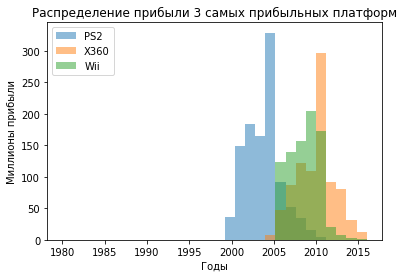

In [14]:
plt.hist(data_for_plot.index, weights=data_for_plot['PS2'], bins = 30, alpha = 0.5, label='PS2')
plt.hist(data_for_plot.index, weights=data_for_plot['X360'], bins = 30, alpha = 0.5, label='X360')
plt.hist(data_for_plot.index, weights=data_for_plot['Wii'], bins = 30, alpha = 0.5, label='Wii')

plt.ylabel('Миллионы прибыли')
plt.xlabel('Годы')
plt.title('Распределение прибыли 3 самых прибыльных платформ')

plt.legend();

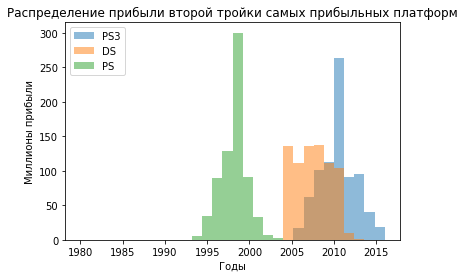

In [15]:
plt.hist(data_for_plot.index, weights=data_for_plot['PS3'], bins = 30, alpha = 0.5, label='PS3')
plt.hist(data_for_plot.index, weights=data_for_plot['DS'], bins = 30, alpha = 0.5, label='DS')
plt.hist(data_for_plot.index, weights=data_for_plot['PS'], bins = 30, alpha = 0.5, label='PS')

plt.ylabel('Миллионы прибыли')
plt.xlabel('Годы')
plt.title('Распределение прибыли второй тройки самых прибыльных платформ')

plt.legend();

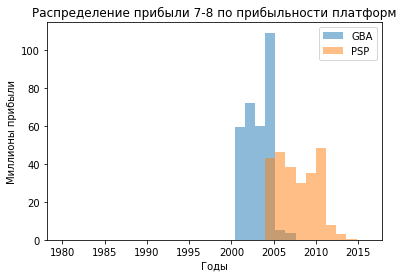

In [16]:
plt.hist(data_for_plot.index, weights=data_for_plot['GBA'], bins = 30, alpha = 0.5, label='GBA')
plt.hist(data_for_plot.index, weights=data_for_plot['PSP'], bins = 30, alpha = 0.5, label='PSP')

plt.ylabel('Миллионы прибыли')
plt.xlabel('Годы')
plt.title('Распределение прибыли 7-8 по прибыльности платформ')

plt.legend();

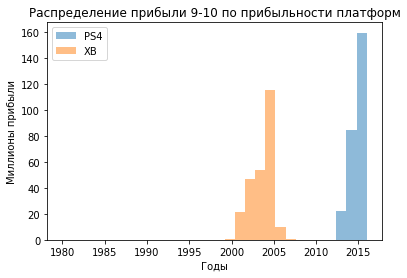

In [17]:
plt.hist(data_for_plot.index, weights=data_for_plot['PS4'], bins = 30, alpha = 0.5, label='PS4')
plt.hist(data_for_plot.index, weights=data_for_plot['XB'], bins = 30, alpha = 0.5, label='XB')

plt.ylabel('Миллионы прибыли')
plt.xlabel('Годы')
plt.title('Распределение прибыли 9-10 по прибыльности платформ')

plt.legend();

In [18]:
def define_duration_support():
    durations_popularity = pd.DataFrame(index=ten_the_most_profitable_platform.index)
    
    for platform in ten_the_most_profitable_platform.index:
        durations_popularity.loc[platform,'duration'] = games_df.query('platform == @platform')['year_of_release'].max() \
        - games_df.query('platform == @platform')['year_of_release'].min()
    
    return durations_popularity

In [19]:
define_duration_support().mean()

duration    10.8
dtype: float64

Взяв 10 самых прибыльных платформ за всю историю рассчитал, что в среднем характерный срок поддержки - 11 лет.

### Данные за актуальный период <a name="actual_data"></a>

In [20]:
modern_games_df = games_df.query('year_of_release > 2011')
the_most_profitable_platform_last_years = modern_games_df.groupby('platform')\
['total_sales'].sum().sort_values(ascending=False)[:5]

the_most_profitable_platform_last_years

platform
PS4     265.79
PS3     245.53
X360    216.14
3DS     186.84
XOne    145.05
Name: total_sales, dtype: float64

In [21]:
try:
    the_most_profitable_platform_last_years = the_most_profitable_platform_last_years.to_frame()
except:
    print('Тип уже приведен, ячейка запускалась')

defective_2012 = modern_games_df.query('year_of_release == 2012 \
        and platform in @the_most_profitable_platform_last_years.index').groupby('platform')['total_sales'].sum()
defective_2012['PS4'] = 0
defective_2012['XOne'] = 0
the_most_profitable_platform_last_years['2012'] = defective_2012

for counter in range(2013, 2017): 
    the_most_profitable_platform_last_years[counter] = modern_games_df.query('year_of_release == @counter \
        and platform in @the_most_profitable_platform_last_years.index').groupby('platform')['total_sales'].sum()      

,total_sales,2012,2013,2014,2015,2016
platform,,,,,,
PS4,265.79,0.00,22.12,84.22,100.44,59.01
PS3,245.53,90.87,95.85,40.88,14.70,3.23
X360,216.14,91.45,80.82,31.61,10.86,1.40
3DS,186.84,48.77,55.07,41.75,26.75,14.50
XOne,145.05,0.00,17.21,49.26,54.67,23.91


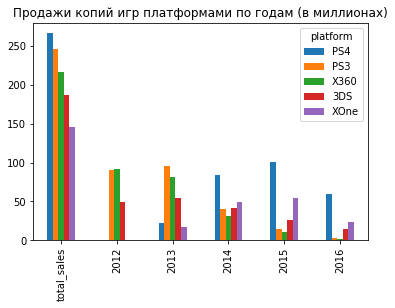

In [22]:
the_most_profitable_platform_last_years.reset_index()
statistics_profit_by_years = the_most_profitable_platform_last_years.T
display(the_most_profitable_platform_last_years)

statistics_profit_by_years.plot(kind='bar', title = 'Продажи копий игр платформами по годам (в миллионах)');

Отобрав пять самых доходных платформ с 2012 года построил их прибыль по годам, выбраны лишь пять самых выгодных платформ, так как у следующих платформ отставание по доходам примерно в два раза.
Погрузившись в 2016: 
- Уже 4 года продаются PS4, исходя из того, что платформы PS весьма популярны в сравнении с иными платформами предложил бы большую часть средств направить на рекламную компанию игр для этой платформы;
- Меньшую сумму предложил бы вложить в игры касающиеся xbox one, которая также существует с 2013 года и предыдущие версии этой платформы всё же хорошо показывали себя.

### Построение boxplot'ов по платформам<a name="boxplots"></a>

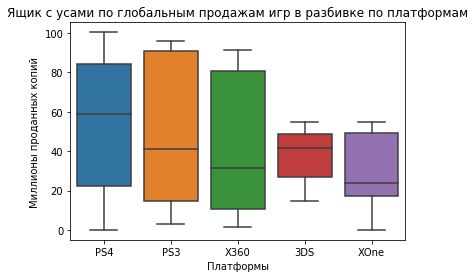

In [23]:
try:
    statistics_profit_by_years.drop('total_sales', inplace = True)
except:
    print('столбец уже удален')  
    
ax = sns.boxplot(data=statistics_profit_by_years)
ax.set_xlabel('Платформы')
ax.set_ylabel('Миллионы проданных копий')
ax.set_title('Ящик с усами по глобальным продажам игр в разбивке по платформам')
plt.show();

Медианные значения числа продаж в год для различных платформ сильно разнятся, однако для трех самых продаваемых платформ с 2012 по 2016 были и одинаково успешные года и года с небольшим примерно равным количеством продаж.

### Влияние отзывов на число продаж <a name="influence_review"></a>

Рассмотрим современную приемницу самой прибыльной платформы за всю историю - PS4. 

In [24]:
name_platform = "PS4"
invalid_score = "-1"

In [25]:
print(f"{modern_games_df.query('platform == @name_platform').shape[0]} - общее количество игр для платформы, " \
      f"{modern_games_df.query('platform == @name_platform and critic_score != @invalid_score and user_score != @invalid_score').shape[0]}"\
      f" - количество игр у которых известны отзывы и критиков и пользователей")

impact_reviews_platform_sales = modern_games_df.query('platform == @name_platform and critic_score != @invalid_score and user_score \
                                               != @invalid_score')
impact_reviews_platform_sales.loc[:,'critic_score'] = impact_reviews_platform_sales['critic_score'].astype('float64')
impact_reviews_platform_sales.loc[:,'user_score'] = impact_reviews_platform_sales['user_score'].astype('float64')

392 - общее количество игр для платформы, 249 - количество игр у которых известны отзывы и критиков и пользователей


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


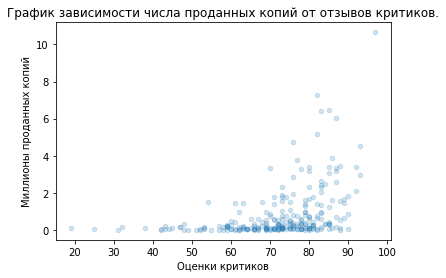

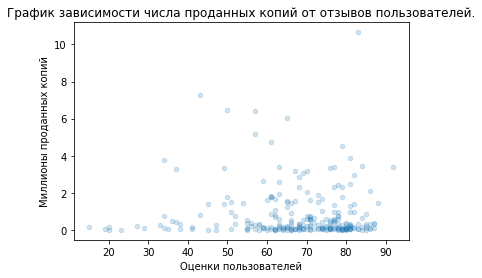

In [26]:
impact_reviews_platform_sales.plot(kind='scatter', y='total_sales', x='critic_score',alpha=0.2)
plt.title("График зависимости числа проданных копий от отзывов критиков.")
plt.xlabel("Оценки критиков")
plt.ylabel("Миллионы проданных копий");

impact_reviews_platform_sales.plot(kind='scatter', y='total_sales', x='user_score',alpha=0.2)
plt.title("График зависимости числа проданных копий от отзывов пользователей.")
plt.xlabel("Оценки пользователей")
plt.ylabel("Миллионы проданных копий");

In [27]:
display(pg.corr(x=impact_reviews_platform_sales['user_score'], y=impact_reviews_platform_sales['total_sales']).
        loc[:,['r','p-val']])
print('Значение корреляции пользовательских оценок и продаж и значение статистики, \
которое не позволяет отвергнуть гипотезу о независимости пользовательских оценок и продаж')

display(pg.corr(x=impact_reviews_platform_sales['critic_score'], y=impact_reviews_platform_sales['total_sales']).
        loc[:,['r','p-val']])
print('Значение корреляции оценок критиков и продаж и значение статистики, \
которое позволяет отвергнуть гипотезу о независимости пользовательских оценок и продаж')

,r,p-val
pearson,-0.032923,0.605128


Значение корреляции пользовательских оценок и продаж и значение статистики, которое не позволяет отвергнуть гипотезу о независимости пользовательских оценок и продаж


,r,p-val
pearson,0.405223,2.939334e-11


Значение корреляции оценок критиков и продаж и значение статистики, которое позволяет отвергнуть гипотезу о независимости пользовательских оценок и продаж


In [28]:
def check_influence_scores_by_sales():
    counter_platform_with_influence_user = 0
    counter_platform_with_influence_critic = 0
    count_platform = 0
    
    for name_platform in modern_games_df['platform'].value_counts().index:
        impact_reviews_platform_sales = modern_games_df.query('platform == @name_platform and critic_score != @invalid_score \
                                                       and user_score != @invalid_score')
        if len(impact_reviews_platform_sales) > 1:
            count_platform += 1
            impact_reviews_platform_sales.loc[:,'critic_score'] = impact_reviews_platform_sales['critic_score'].astype('float64')
            impact_reviews_platform_sales.loc[:,'user_score'] = impact_reviews_platform_sales['user_score'].astype('float64')
        
            if pg.corr(x=impact_reviews_platform_sales['critic_score'], 
                       y=impact_reviews_platform_sales['total_sales']).loc[:,'p-val']['pearson'] < 0.05:
                counter_platform_with_influence_critic += 1
        
            if pg.corr(x=impact_reviews_platform_sales['user_score'], 
                       y=impact_reviews_platform_sales['total_sales']).loc[:,'p-val']['pearson'] < 0.05:
                counter_platform_with_influence_user += 1
            
    print(f'Платформ всего с отзывами критиков и пользователей - {count_platform}, платформ, влияние на число продаж игр '
          f'которых оказали отзывы критиков - {counter_platform_with_influence_critic}, платформ, влияние на число продаж '
          f'игр которых оказали отзывы пользователей - {counter_platform_with_influence_user}')
    
    return None

check_influence_scores_by_sales()

Платформ всего с отзывами критиков и пользователей - 9, платформ, влияние на число продаж игр которых оказали отзывы критиков - 7, платформ, влияние на число продаж игр которых оказали отзывы пользователей - 2


### Влияние жанров на продажи <a name="influence_genres"></a>

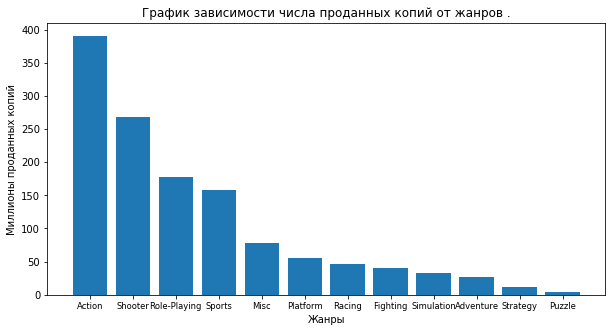

In [29]:
modern_games_df.groupby('genre')
games_by_genre = modern_games_df.pivot_table(index='genre', values='total_sales', aggfunc=['sum','count'])
games_by_genre.columns = ['total_sales', 'total_count_games']
games_by_genre = games_by_genre.sort_values('total_sales',ascending=False)

plt.figure(figsize=(10,5))
plt.bar(range(len(games_by_genre['total_sales'])), games_by_genre['total_sales'].values, align='center')
plt.xticks(range(len(games_by_genre['total_sales'])), games_by_genre['total_sales'].index.values, size='small')
plt.title("График зависимости числа проданных копий от жанров .")
plt.xlabel("Жанры")
plt.ylabel("Миллионы проданных копий");
plt.show()

Всё же основное предназначени игр судя по полученным данным - не скучное времяпрепровождение, первые пять жанров предполагают повышенное внимание от играющего, эти жанры динамичны, что находит большой спрос среди играющих. Напротив же игры с меньшими продажами предполагают чуть больше аналитических способностей, развитие действий в этих игра х более замедленное. Полагаю, что динамичность игры - один из определяющих факторов, влияющих на успешность игры.

### Первично обнаруженные закономерности <a name="primary_patterns"></a>


* Пользовательские оценки виляют на суммарные продаже в отличии от оценок экспертов;
* Существуют довольно популярные жанры, такие как Action, Shooter, которые хорошо продаются;
* Зачастую жанры в которых высокая динамика популярнее, а спокойные и требующие умственных усилий продаются хуже.

## Шаг 4. Портрет пользователя каждого региона <a name="portrait_by_regions"></a>

### Самые популярные платформы <a name="famous_platforms"></a> 

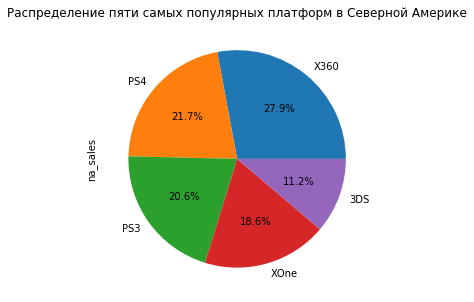

In [30]:
popular_platforms_sa = modern_games_df.groupby('platform')['na_sales'].sum().sort_values(ascending=False)[:5]
plot_platforms_sa = popular_platforms_sa.plot.pie(subplots=True, figsize=(5, 5), autopct='%1.1f%%')
plt.title('Распределение пяти самых популярных платформ в Северной Америке');

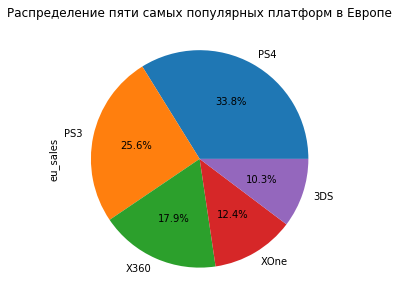

In [31]:
popular_platforms_eu = modern_games_df.groupby('platform')['eu_sales'].sum().sort_values(ascending=False)[:5]
plot_platforms_eu = popular_platforms_eu.plot.pie(subplots=True, figsize=(5, 5),autopct='%1.1f%%')
plt.title('Распределение пяти самых популярных платформ в Европе');

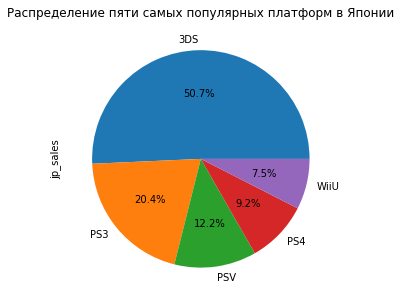

In [32]:
popular_platforms_jp = modern_games_df.groupby('platform')['jp_sales'].sum().sort_values(ascending=False)[:5]
plot_platforms_jp = popular_platforms_jp.plot.pie(subplots=True, figsize=(5, 5),autopct='%1.1f%%')
plt.title('Распределение пяти самых популярных платформ в Японии');

Топ 5 самых популярных платформ отличается в каждом регионе, однако Европа и Северная Америка отличаются лишь популярностью разных платформ, а вот в Японии больше уникальных платформ, считаю не удивительным, что в Японии популярны платформы, которые там и разрабатывались, также обращаю внимание на схожесть вкусов европейцев и американцев.

### Самые популярные жанры <a name="famous_genres"></a>

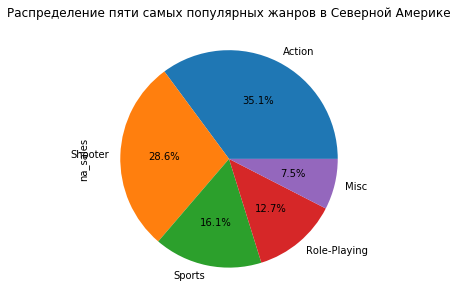

In [33]:
popular_genres_sa = modern_games_df.groupby('genre')['na_sales'].sum().sort_values(ascending=False)[:5]
plot_genres_sa = popular_genres_sa.plot.pie(subplots=True, figsize=(5, 5),autopct='%1.1f%%')
plt.title('Распределение пяти самых популярных жанров в Северной Америке');

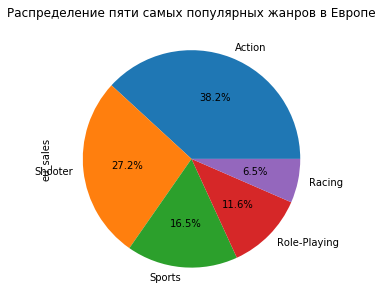

In [34]:
popular_genres_eu = modern_games_df.groupby('genre')['eu_sales'].sum().sort_values(ascending=False)[:5]
plot_genres_eu = popular_genres_eu.plot.pie(subplots=True, figsize=(5, 5),autopct='%1.1f%%')
plt.title('Распределение пяти самых популярных жанров в Европе');

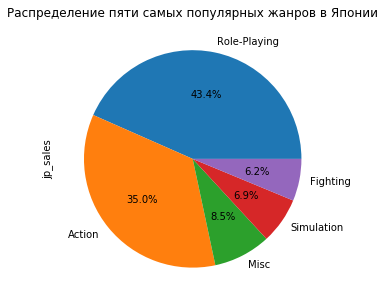

In [35]:
popular_genres_jp = modern_games_df.groupby('genre')['jp_sales'].sum().sort_values(ascending=False)[:5]
plot_genres_jp = popular_genres_jp.plot.pie(subplots=True, figsize=(5, 5),autopct='%1.1f%%')
plt.title('Распределение пяти самых популярных жанров в Японии');

Вновь наблюдается сходство Европы и Северной Америке, в этот раз также различие оказалось лишь в одном жанре игр, европейцам больше нравятся гоночки, а вот американцам игры иных жанров, ну а у Японии свой путь, Самым популярным является жанр ролевых игр, которые лишь четвертые в остальном мире.

### Влияние ESRB на продажи в регионах <a name="ESRB_seller"></a>

In [36]:
modern_games_df.loc[:, 'rating_id'] = modern_games_df['rating'].astype('category')
cat_columns = modern_games_df.select_dtypes(['category']).columns
modern_games_df.loc[:, 'rating_id'] = modern_games_df[cat_columns].apply(lambda x: x.cat.codes)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


In [37]:
modern_games_df.query('rating_id != 8').rcorr(stars=False)

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales,rating_id
year_of_release,-,0.000,0.005,0.001,0.002,0.004,0.293,0.000,0.143
na_sales,-0.092,-,0.,0.000,0.,0.000,0.000,0.,0.000
eu_sales,-0.053,0.767,-,0.000,0.,0.000,0.000,0.,0.000
jp_sales,-0.063,0.271,0.265,-,0.000,0.446,0.178,0.000,0.004
other_sales,-0.057,0.792,0.937,0.203,-,0.000,0.000,0.,0.000
critic_score,-0.053,0.257,0.252,-0.014,0.244,-,0.,0.000,0.000
user_score,-0.02,0.194,0.181,-0.025,0.18,0.839,-,0.000,0.000
total_sales,-0.086,0.926,0.912,0.48,0.882,0.245,0.178,-,0.000
rating_id,0.027,-0.172,-0.174,0.053,-0.154,-0.546,-0.603,-0.157,-


В нижнем треугольнике значения корреляции, в верхнем - p-значения, согласно результатам статистического теста, если значение p выше 0,05, можем сказать, что между двумя переменными не существует значительной корреляции. Проинализировав последний столбец гипотеза о влиянии ESRB на продажи в регионах не может быть отвергнута.

### Выводы о специфичности регионов <a name="specific_regions"></a>

* Япония отличается от Америки и Европы, используются специфические платформы, которые созданы в Японии;
* Популярные жанры в различных регионах схожи, однако в случае вложения в рекламную программу в Японии рекомендую обратить внимания на ролевые игры;
* Согласно результатам тестов на продажи влияют все факторы.

## Шаг 5. Проверка гипотез <a name="step5"></a>

### Гипотеза 1 <a name="hyp1"></a>

Нулевая гипотеза - средние пользовательские рейтинги платформ Xbox One и PC равны между собой.

Альтернативная - средние пользовательские рейтинги платформ Xbox One и PC не равны между собой.

#### Проверка равенства дисперсий выборок рейтингов платформ Xbox One и PC <a name="var_rating_platform"></a>

In [38]:
alpha = .05
games_df_platform_XO = modern_games_df.query('platform == "XOne" and user_score != @invalid_score')['user_score'].astype('float64')
games_df_platform_PC = modern_games_df.query('platform == "PC" and user_score != @invalid_score')['user_score'].astype('float64')

stat, p = st.levene(games_df_platform_PC.values, games_df_platform_XO.values)
print('p-значение:', p)

if (p < alpha):
    print("Отвергаем гипотезу о равенстве дисперсий")
else:
    print("Принимаем гипотезу о равенстве дисперсий") 

p-значение: 0.01251484281850554
Отвергаем гипотезу о равенстве дисперсий


Воспользовавшись тестом Левена для проверки равенства дисперсий в группах можем осознанно использовать Т-критерий Стьюдента с опцией показывающей равенство дисперсий.

#### Проверка равенства средних  пользовательских рейтингов платформ Xbox One и PC  <a name="mean_platform"></a>

In [39]:
results_hypothesis_equality_tests = st.ttest_ind(
    games_df_platform_XO, 
    games_df_platform_PC, equal_var = False)

print('p-значение:', results_hypothesis_equality_tests.pvalue)

if (results_hypothesis_equality_tests.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
    
pg.ttest(games_df_platform_XO, games_df_platform_PC, correction='auto').round(2)

p-значение: 0.5489537965135056
Не получилось отвергнуть нулевую гипотезу


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,0.6,384.52,two-sided,0.55,"[-2.11, 3.97]",0.06,0.134,0.09


#### Вывод на основе гипотезы 1 <a name="conclusion_hyp1"></a>

По результатам, получившимся на основе статистического теста не удалось отвергнуть гипотезу о равенстве средних  пользовательских рейтингов платформ Xbox One и PC.

### Гипотеза 2 <a name="hyp2"></a>

Нулевая гипотеза - средние пользовательские рейтинги жанров Action и Sports равны между собой.

Альтернативная - средние пользовательские рейтинги жанров Action и Sports не равны между собой.

#### Проверка равенства дисперсий выборок рейтингов жанров Action и Sports <a name="var_rating_action"></a>

In [40]:
games_df_genre_sports = modern_games_df.query('genre == "Sports" and user_score != @invalid_score')['user_score'].astype('float64')
games_df_genre_action = modern_games_df.query('genre == "Action" and user_score != @invalid_score')['user_score'].\
sample(games_df_genre_sports.count(), random_state=42).astype('float64')

stat, p = st.levene(games_df_genre_action.values, games_df_genre_sports.values)
print('p-значение:', p)

if (p < alpha):
    print("Отвергаем гипотезу о равенстве дисперсий")
else:
    print("Нулевая гипотеза о равенстве дисперсий не отвергнута") 

p-значение: 0.0016632146005287347
Отвергаем гипотезу о равенстве дисперсий


#### Проверка равенства рейтингов жанров Action и Sports  <a name="mean_genre"></a>

In [41]:
results_hypothesis_equality_tests = st.ttest_ind(
    games_df_genre_sports, 
    games_df_genre_action, equal_var = False)

print('p-значение:', results_hypothesis_equality_tests.pvalue)

if (results_hypothesis_equality_tests.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Нулевая гипотеза не отвергнута") 
    
pg.ttest(games_df_genre_sports, games_df_genre_action, correction='auto')

p-значение: 7.062621645607358e-18
Отвергаем нулевую гипотезу


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-9.065324,388,two-sided,6.236998e-18,"[-17.8, -11.46]",0.918081,7.272e+14,1.0


#### Вывод на основе гипотезы 2 <a name="conclusion_hyp2"></a>

Гипотеза о равенстве средних пользовательских рейтингов жанров Action и Sports на основе теста была отвергнута.

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применил метод scipy.stats.ttest_ind, предназначенный для проверки гипотез о равенстве средних. Гипотезу, которую необходимо было проверить использовал как альтернативную по причине простоты проверки гипотезы о равенстве средних в двух выборках.

## Шаг 6. Общий вывод <a name="general_conclusion"></a> 


В процессе предварительного анализа данных было выявлено следующее:
* В столбцах name и genre пропуски малочисленны и невосполнимы в связи с чем просто удалил строки содержащие пропуски;
* В столбце year_of_release заменил пропуски на среднее значение, чтобы медиану не подвинуть и при этом вычленить в будущем строки с изначальным пропуском;
* Что касается замен рейтингов:
    * Зависимостей по имеющимся данным выявлено не было;
    * Заменять на какое-то среднее или медианное значение посчитал невозможным, по причине потери информации от игр с действительно указанным и не указанным рейтингом;
    * Существование значения оценое 'tbd' подсказало как поступить с пропущенными значениями, для использования информации о пропущенных значениях они были выделены в отдельные классы со значениями 'tbd' для оценок и 'pass_rating' для рейтинга ESRB 
    
Выделяю следующие причины возникновения пропусков:
* Отсутствие каких-то параметров о строках;
* Еще несформированные характеристики для игр;
* Сертификационный центр не успел присвоить рейтинг.

Также было выяснено, что актуальными можно считать данные об играх начиная с 2012 года, когда произошло существенное уменьшение выпущенных игр за год, причинами которого считаю следующие:

* Повышение сложности создания отдельной игры;
* По информации на Metacritic (сайт-агрегатор отзывов), лучших игр десятилетия 2010-2019 до 2016 года - 33, 11 из них были выпущены в 2011, окончание работы по столь большому количество признанных проектов считаю одним из оснований по снижению числа игр в 2012.

Определил, что средняя продолжительность поддержки игр для платформы - 11 лет в связи с чем на последующий год отобрал следующие платформы для инвестирования в рекламные программы:

- PS4, исходя из того, что платформы PS весьма популярны в сравнении с иными платформами предложил бы большую часть средств направить на рекламную компанию игр для этой платформы;
- Меньшую сумму предложил бы вложить в игры касающиеся xbox one, которая также существует с 2013 года и предыдущие версии этой платформы всё же хорошо показывала себя.

Проанализировав предпочтения пользователей по жанрам рекомендовано инвестировать в следующие жанры:
- Action - жанр популярный во всех регионах;
- Sports - также популярный жанр вне зависимости от региона;
- В случае желания инвестировать в рекламные компаниии на территории Япониии рекомендую обратить внимания на жанр игр - Role-Playning - жанр, который предпочитают 33 процента всех играющих японцев.

Была отвергнута гипотеза о схожести пользовательских оценок платформ PC и Xbox One, при этом по имеющимся данным не удалось отвергнуть гипотезу о подобности пользовательских оценок жанра Action и Sports. 

Рекомендовано при выборе игр, в рекламную компанию которых собираемся инвестировать обращать внимания на следующие пункты:
- Жанр игры популярные - Action, Sports, Role-Playning - в Японии;
- Платформа, считаю потенциально прибыльными - Ps4, X One;
- Отзывы считаю посредственно важным фактором - если отзыв более 80% от максимума, то чему он конкретно равен не так важно;
